#Прогнозирование сердечной недостаточности
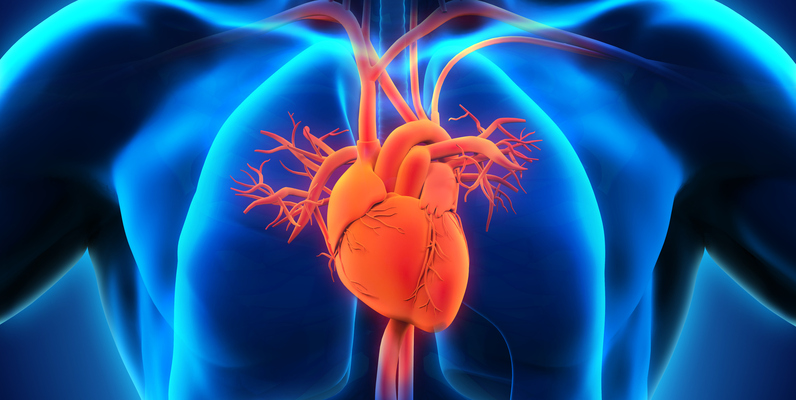

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# 1. Загрузка данных

Монтируем Google Disk и переходим в папку с нашими данными:

In [2]:
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/homework_neymark/archive/
data_raw = pd.read_csv('heart.csv')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/homework_neymark/archive


Вначале посмотрим на размеры таблицы: количество строк (каждая строка соответствует одному пациенту) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [3]:
data_raw.shape

(918, 12)

Посмотрим на данные первых 5 пациентов:

In [4]:
data_raw.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Посмотрим на данные последних 5 пациентов:

In [5]:
data_raw.tail(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


#2. Описание датасета

In [6]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


**Информация о признаках**
* `Age` - возраст пациента [лет]
* `Sex` - пол пациента [М: Мужской, Ж: Женский]
* `ChestPainType` - тип боли в груди [TA: типичная стенокардия, ATA: атипичная стенокардия, NAP: неангинальная боль, ASY: бессимптомная]
* `RestingBP` - артериальное давление в состоянии покоя [мм рт.ст.]
* `Cholesterol` - холестерин сыворотки [мг/дл]
* `FastingBS` - уровень сахара в крови натощак [1: если FastingBS > 120 мг/дл, 0: иначе]
* `ReastingECG` - результаты электрокардиограммы в покое [норма: нормальная, ST: аномалия ST-T (инверсия зубца T и/или подъем или депрессия ST > 0,05 мВ), ГЛЖ: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса]
* `MaxHR` - максимальная достигнутая частота сердечных сокращений [Числовое значение от 60 до 202]
* `ExerciseAngina` - стенокардия, вызванная физической нагрузкой [Д: Да, Н: Нет]
* `Oldpeak` - старый пик = ST [Числовое значение, измеренное в депрессии]
* `ST_Slope` - наклон сегмента ST пикового упражнения [Вверх: восходящий, Плоский: плоский, Вниз: нисходящий]
* `HeartDisease` - выходной класс [1: болезнь сердца, 0: нормальный]

Следующие признаки являются категориальными: `Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina` и `ST_Slope`, остальные признаки являются количественными.
Требуется предсказать бинарный количественный признак `HeartDisease` по остальным признакам. Задача классификации.

Столбцы `'Sex'`, `'ChestPaintType'`, `'RestingECG'`, `'ExerciseAngina'` и `'ST_Slope'` содержат категориальные значения и имеют тип `'Object'`. Заменим тип на специальный, предназначенный для хранения категориальный значений:

In [7]:
data_raw['Sex'] = data_raw['Sex'].astype('category')
data_raw['ChestPainType'] = data_raw['ChestPainType'].astype('category')
data_raw['RestingECG'] = data_raw['RestingECG'].astype('category')
data_raw['ExerciseAngina'] = data_raw['ExerciseAngina'].astype('category')
data_raw['ST_Slope'] = data_raw['ST_Slope'].astype('category')

Посмотрим информацию о числовых признаках:

In [8]:
data_raw.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Информация о категориальных признаках:

In [9]:
data_raw.describe(include=['category'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


#3. Анализ и обработка данных

Посмотрим на баланс классов:

Количество людей с сердечной недостаточностью: 508
Количество здоровых людей: 410
Общее количество обследованных людей: 918


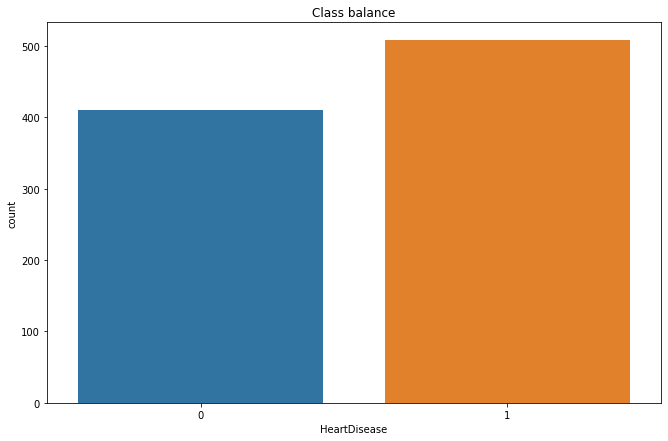

In [10]:
fig, ax = plt.subplots(figsize=(11, 7))
p = sns.countplot(ax=ax, x=data_raw['HeartDisease'])
_ = p.set_title("Class balance")

HeartDiseasePeople = data_raw[data_raw['HeartDisease'] == 1].shape[0]
print("Количество людей с сердечной недостаточностью:", HeartDiseasePeople)
print("Количество здоровых людей:", data_raw.shape[0] - HeartDiseasePeople)
print("Общее количество обследованных людей:", data_raw.shape[0])

Баланс классов примерно равный, соотношение **410/508** с преобладанием класса людей с сердечной недостаточностью.


Далее построим все диаграммы рассеивания c выделением сердечной недостаточности:

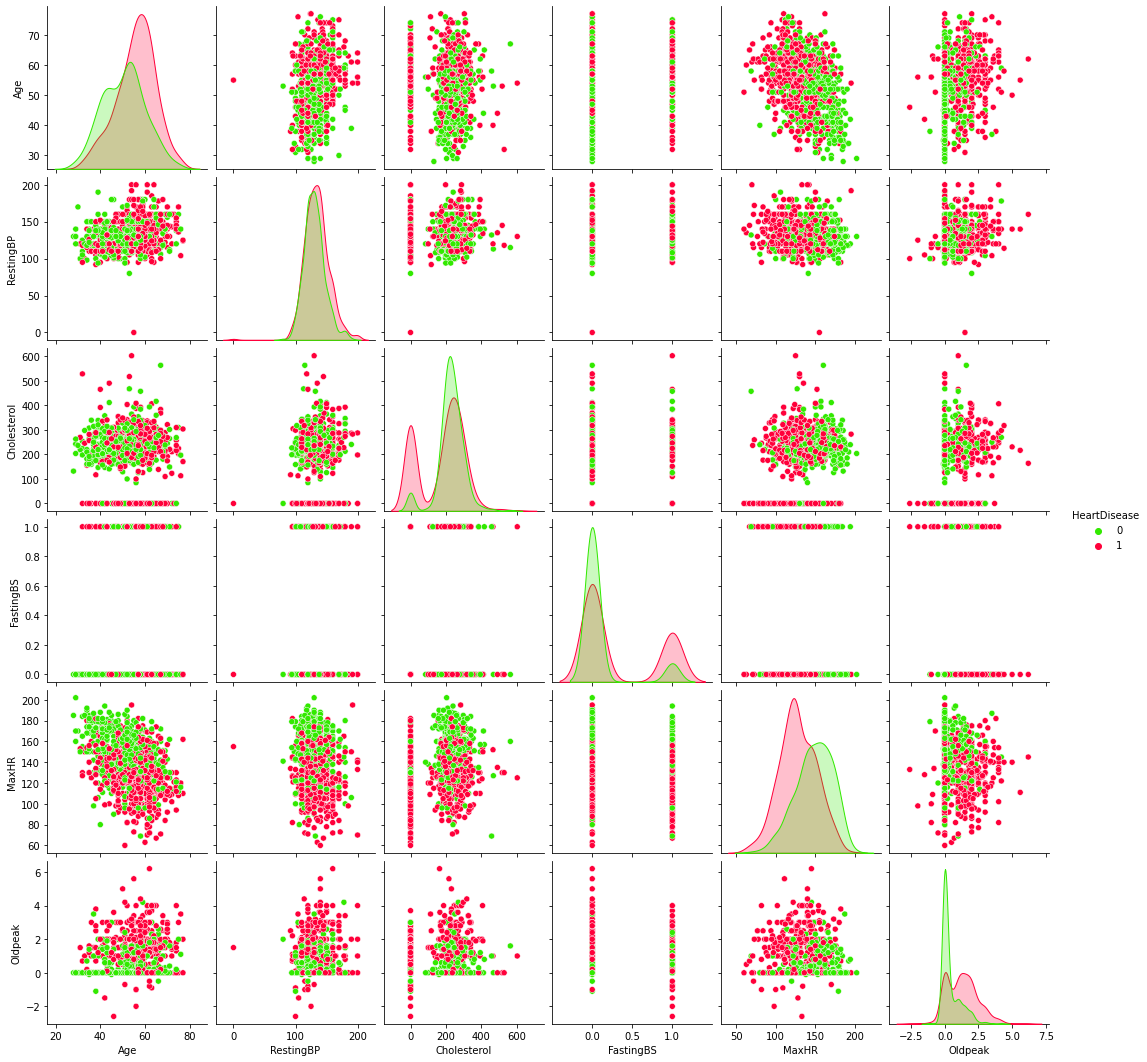

In [11]:
sns.pairplot(data=data_raw, hue='HeartDisease', palette='prism')
pass

#3.1 Обработка пропущенных значений

Проверим все признаки на пропуски и отдельно проверим признаки `'Age'`, `'RestingBP'`, `'Cholesterol'` и `'MaxHR'` на нулевые значения:

In [12]:
data_raw.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [13]:
count_none_value = 0

df = data_raw[data_raw['Age'] == 0]
print("Количество нулевых значений возраста:", df.shape[0])
count_none_value += df.shape[0]

df = data_raw[data_raw['Cholesterol'] == 0]
print("Количество нулевых значений холестерина:", df.shape[0])
count_none_value += df.shape[0]

df = data_raw[data_raw['RestingBP'] == 0]
print("Количество нулевых значений артериального давления:", df.shape[0])
count_none_value += df.shape[0]

df = data_raw[data_raw['MaxHR'] == 0]
print("Количество нулевых значений максимальной частоты пульса:", df.shape[0])
count_none_value += df.shape[0]

print("\nПроцент пропущенных значений признаков:", count_none_value / (data_raw.shape[0] * (data_raw.shape[1] - 1))  * 100)

Количество нулевых значений возраста: 0
Количество нулевых значений холестерина: 172
Количество нулевых значений артериального давления: 1
Количество нулевых значений максимальной частоты пульса: 0

Процент пропущенных значений признаков: 1.7132105367399484


Как можно заметить, **172 наблюдения** имеют нулевое значение холестерина, что в реальности быть не может. Поэтому давайте заполним нулевые значения средним по признаку, так же поступим с артериальным давлением:

In [14]:
df = data_raw[data_raw['Cholesterol'] > 0]
mean = df['Cholesterol'].sum() / df['Cholesterol'].count() # or df['Cholesterol'].mean()
data_raw.loc[data_raw['Cholesterol'] == 0, 'Cholesterol'] = mean

df = data_raw[data_raw['RestingBP'] > 0]
mean = df['RestingBP'].mean()
data_raw.loc[data_raw['RestingBP'] == 0, 'RestingBP'] = mean

#3.2 Обработка выбросов

Теперь давайте подробнее рассмотрим признаки `'Cholesterol'`, `'RestingBP'` и `'MaxHR'` на наличие выбросов и посмотрим на квантили принимаемых значений:

,Cholesterol,RestingBP,MaxHR
0.005,115.340000,95.00,70.585
0.010,129.340000,95.17,77.170
0.050,168.000000,107.70,96.000
0.100,186.000000,110.00,103.000
0.500,244.635389,130.00,138.000
0.900,305.000000,160.00,170.000
0.950,331.300000,160.00,178.000
0.990,411.490000,180.00,186.000
0.995,477.545000,190.83,190.000


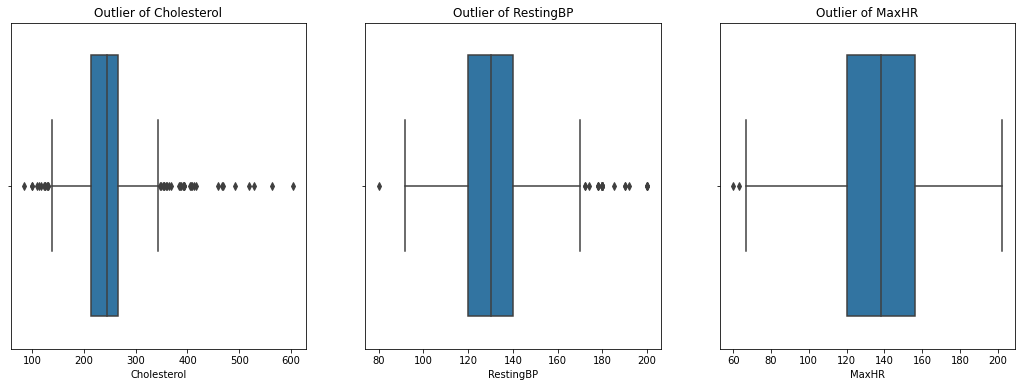

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

p = sns.boxplot(ax=axes[0], x=data_raw['Cholesterol'])
_ = p.set_title("Outlier of Cholesterol")

p = sns.boxplot(ax=axes[1], x=data_raw['RestingBP'])
_ = p.set_title("Outlier of RestingBP")

p = sns.boxplot(ax=axes[2], x=data_raw['MaxHR'])
_= p.set_title("Outlier of MaxHR")

data_raw[['Cholesterol', 'RestingBP', 'MaxHR']].quantile([0.005, .01, .05, .1, .5, .9, .95, .99, .995])

Подведем некоторый итог построенных по результатам:
* **99%** всех значений `'Cholesterol'` находится в диапозоне от **115** до **478** мг/дл
* **99%** всех значений `'RestingBP'` находится в диапозоне от **95** до **191** мм.рт.ст.
* **99%** всех значений `'MaxHR'` находится в диапозоне от **70** до **190** удара в минуту

Удалим все строки таблицы, в которых `'Cholesterol'`, `'RestingBP'` или `'MaxHR'` выходят за пределы кванитилей **0.005**, **0.995**:

In [16]:
rows_to_drop = data_raw[
    (data_raw['Cholesterol'] < data_raw['Cholesterol'].quantile(0.005)) | (data_raw['Cholesterol'] > data_raw['Cholesterol'].quantile(0.995)) |
    (data_raw['RestingBP'] < data_raw['RestingBP'].quantile(0.005)) | (data_raw['RestingBP'] > data_raw['RestingBP'].quantile(0.995)) |
    (data_raw['MaxHR'] < data_raw['MaxHR'].quantile(0.005)) | (data_raw['MaxHR'] > data_raw['MaxHR'].quantile(0.995))].index

print("Процент найденных выбросов:", rows_to_drop.shape[0] / data_raw.shape[0] * 100)
data = data_raw.drop(rows_to_drop)

Процент найденных выбросов: 2.832244008714597


#3.3 Интерпретация некоторых признаков

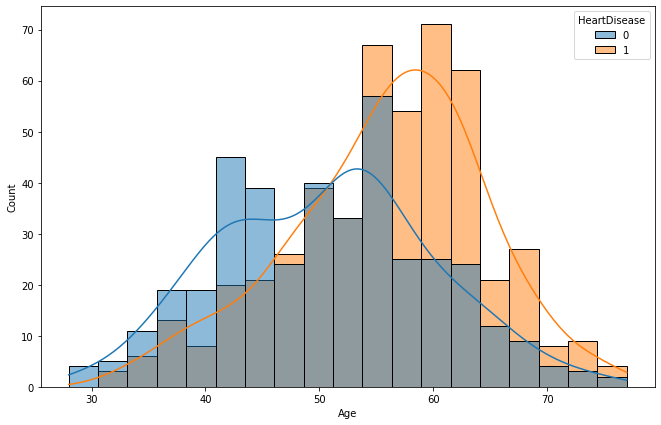

In [17]:
plt.figure(figsize=(11, 7))
sns.histplot(x='Age', hue='HeartDisease', kde=True, data=data)
pass

По гистограмме можно заметить, что сердечная недостаточность начинает преобладать у большинства людей с возраста **55 лет**.

Интересный факт, что людей, страдающих сердечной недостаточностью, всех больше в возрасте **58 лет**. В этот пероид люди начинают, как правило, страдать от возможных симптомов, вследствие этого имеют шанс умереть:

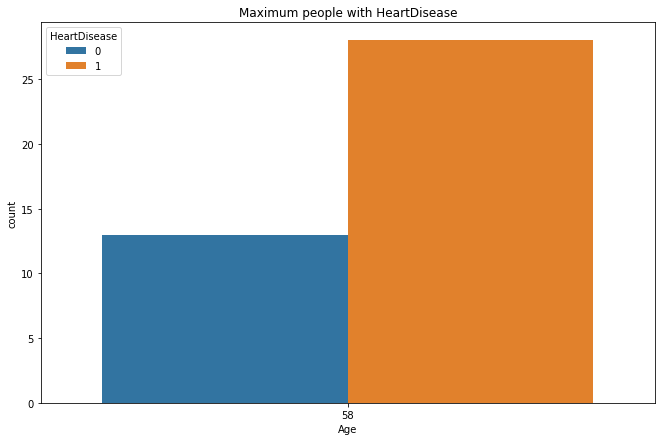

In [18]:
plt.figure(figsize=(11, 7))
p = sns.countplot(x='Age', hue='HeartDisease', data=data[data['Age'] == 58])
_ = p.set_title("Maximum people with HeartDisease")

Теперь давайте посмотрим зависимость между полом человека и сердечной недостаточностью:

Количество обследованных женщин: 188
Количество обследованных мужчин: 704


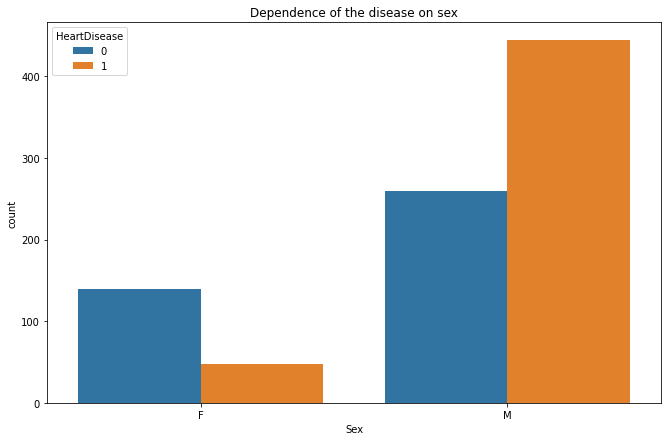

In [19]:
print("Количество обследованных женщин:", data[data['Sex'] == 'F'].shape[0])
print("Количество обследованных мужчин:", data[data['Sex'] == 'M'].shape[0])

plt.figure(figsize=(11, 7))
p = sns.countplot(x='Sex', hue='HeartDisease', data=data)
_ = p.set_title("Dependence of the disease on sex")

Даже с большим преобладанием обследованных мужчин можно сказать, что процентное наличие заболевания сердечной недостаточности у мужского пола намного выше, чем у женского.

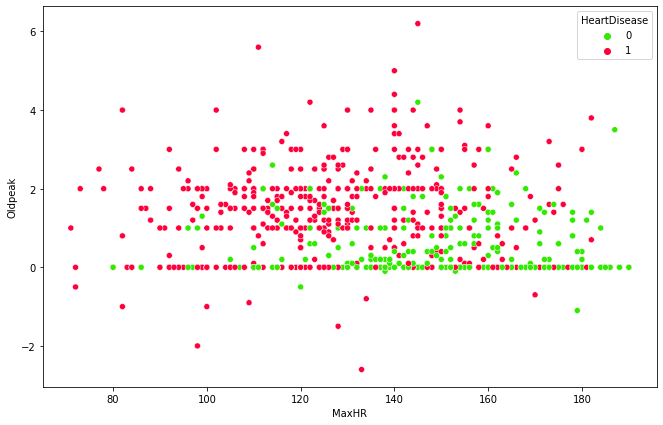

In [20]:
plt.figure(figsize=(11, 7))
sns.scatterplot(x='MaxHR', y='Oldpeak', hue='HeartDisease', data=data, palette='prism')
pass

Большая часть здоровых людей сфокусирована в правой части графика. Делаем вывод, что у людей с наиболее высоким достигнутым значением сердцебиения (возможно замеренного после нескольких приседаний или любой другой активности) заболевание сердечной недостаточнотью намного ниже. Так же можно утверждать, что величина старого пика скорее всего отрицательно влияет на здоровье человека.

#3.4 Выявление зависимых признаков

Вычислим матрицу корреляции для количественных признаков:

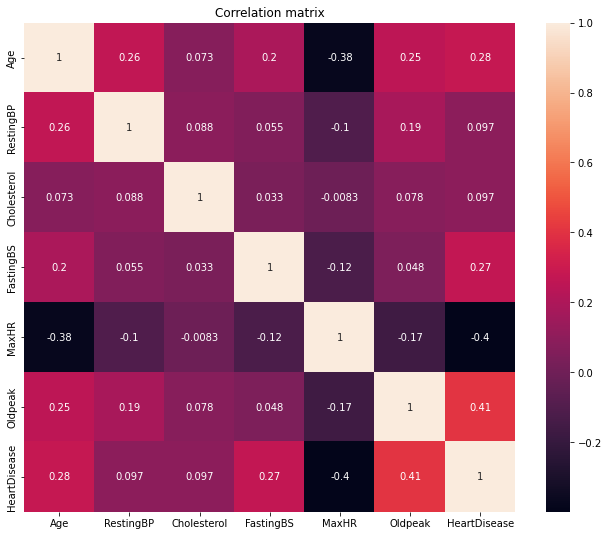

In [21]:
corr_mat = data.corr()
plt.figure(figsize=(11, 9))
p = sns.heatmap(corr_mat, annot=True)
_ = p.set_title("Correlation matrix")

Из корреляционной матрицы видно, что признаки `'MaxHR'` и `'Oldpeak'` оказывают наибольшее влияние на развитие сердечной недостаточности в то время, как `'RestingBP'` и `'Cholesterol'` наименьшее. Кроме этого можно выделить пару самых независимых друг от друга признаков - это `'Cholesterol'` и `'MaxHR'`, что в целом укладывается в логику вещей, так как данные понятия по природе человека не связаны.

#3.5 Кодирование категориальных признаков

Кодировать признаки будем с помощью `one-hot-encoder`:

In [22]:
enc = OneHotEncoder(drop='if_binary', sparse=False)
enc.fit(data[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']])

OneHotEncoder(drop='if_binary', sparse=False)

In [23]:
data_one_hot = pd.DataFrame(enc.transform(data[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]),
                    columns=enc.get_feature_names_out(), index=data.index)
data = pd.concat((data, data_one_hot), axis=1).drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1)

После этого будет интересно вернуться к корреляционной матрице и посмотреть на новые значения:

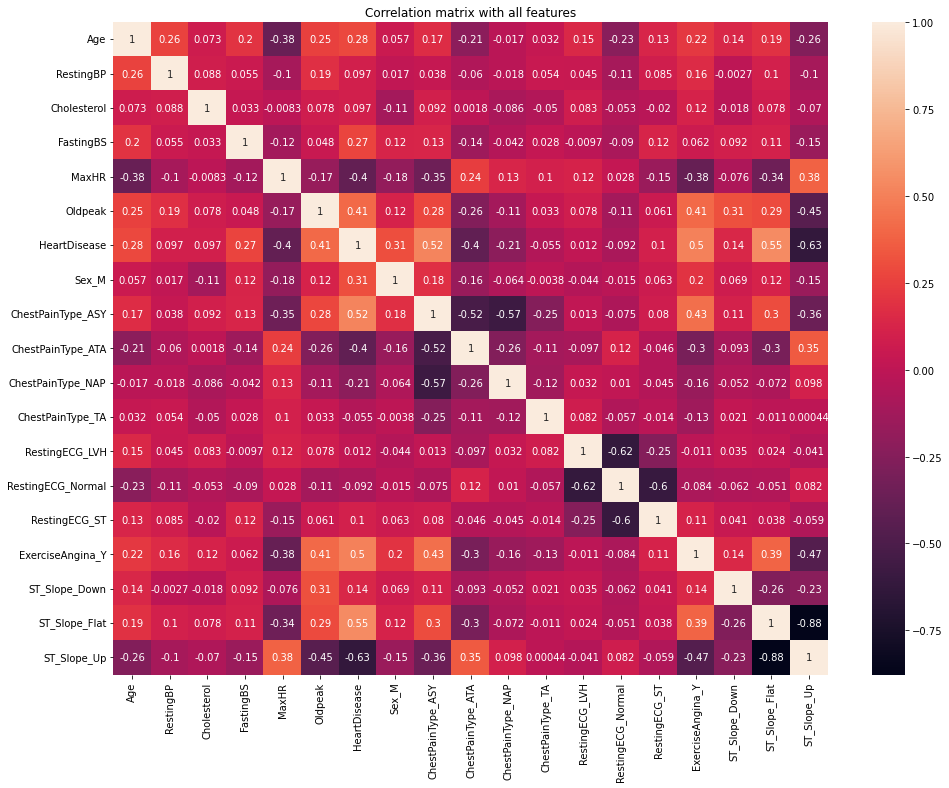

In [24]:
corr_mat = data.corr()
plt.figure(figsize=(16, 12))
p = sns.heatmap(corr_mat, annot=True)
_ = p.set_title("Correlation matrix with all features")

Теперь можно заметить, что `'HeartDisease'` набиолее зависит от `'ST_Slope_UP'`. А также можно сделать вывод, что `'ST_Slope_Up'` и `'ST_SlopeFlat'` довольно похожие по притовоположности признаки.

#3.6 Разбиение данных на обучающую и тестовую выборки

Для предсказания сердечной недостаточности будем использовать все входные признаки, кроме `'HeartDisease'`.

In [25]:
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify = y)

print("Размер обучающей выборки:", X_train.shape[0])
print("Размер тестовой выборки:", X_test.shape[0])

Размер обучающей выборки: 669
Размер тестовой выборки: 223


Еще раз посмотрим на баланс классов уже обучающей выборки:

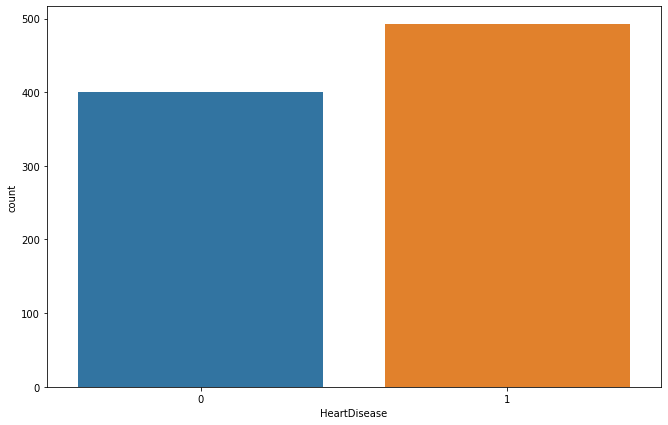

In [27]:
fig, ax = plt.subplots(figsize=(11, 7))
p = sns.countplot(ax=ax, x='HeartDisease', data=data)

#3.7 Масштабирование признаков

* стандартизация - линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению.

Выполним стандартизацию всех признаков:

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#4. Классификация

Напишем универсальную функцию оценивания метрик и построения графиков для будущих моделей:

In [29]:
def evaluate(model, y_train_pred, y_train, y_test_pred, y_test) -> None:
  """
  calculate several metrics and show bar: accuracy, F1 score, ROC-AUC

  :param: model
  :param: y_train_pred - train predictions
  :param: y_train - train targets
  :param: y_test_pred - test predictions 
  :param: y_test - test targets
  """

  accuracy_train = accuracy_score(y_train_pred, y_train)
  accuracy_test = accuracy_score(y_test_pred, y_test)
  f1_train_score = f1_score(y_train_pred, y_train)
  f1_test_score = f1_score(y_test_pred, y_test)
  roc_auc_train = roc_auc_score(y_train_pred, y_train)
  roc_auc_test = roc_auc_score(y_test_pred, y_test)

  plt.figure(figsize=(11, 7))
  plt.ylim(top=1)
  ax1 = plt.bar([0, 1.5, 3], [accuracy_train, f1_train_score, roc_auc_train], color='lightpink', width=0.5)
  ax2 = plt.bar([0.5, 2, 3.5], [accuracy_test, f1_test_score, roc_auc_test], color='orchid', width=0.5)
  plt.xticks(ticks=[0.25, 1.75, 3.25], labels=['accuracy', 'F1 score', 'ROC-AUC'])
  plt.legend((ax1, ax2), ['train', 'test'])
  plt.title("Several main metrics")
  plt.ylabel("value")


  print("Train accuracy:", accuracy_train)
  print("Test  accuracy:", accuracy_test)

  print("\nTrain F1 score:", f1_train_score)
  print("Test  F1 score:", f1_test_score)

  print("\nTrain ROC-AUC:", roc_auc_train)
  print("Test  ROC-AUC:", roc_auc_test)

#4.1 KNN

Давайте теперь посмотрим, как будет меняться `accuracy` в зависимости от числа ближайших соседей, и подберем наилучшее значение по тестовой выборке: 

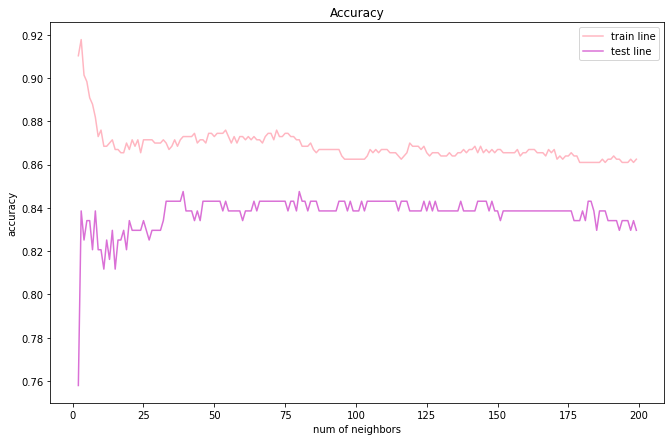

In [30]:
accuracy_train_hist = []
accuracy_test_hist = []
k_best = 2
max_accuracy = 0

for k in range(2, 200):
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  accuracy_train_hist.append(accuracy_score(y_train_pred, y_train))
  accuracy_test_hist.append(accuracy_score(y_test_pred, y_test))

  if (accuracy_test_hist[-1] > max_accuracy):
    max_accuracy = accuracy_test_hist[-1]
    k_best = k

plt.figure(figsize=(11, 7))
line_train, = plt.plot(range(2, 200), accuracy_train_hist, color='lightpink')
line_test, = plt.plot(range(2, 200), accuracy_test_hist, color='orchid')
plt.legend((line_train, line_test), ['train line', 'test line'])
plt.title('Accuracy')
plt.xlabel('num of neighbors')
plt.ylabel('accuracy')
pass

А теперь давайте рассмотрим другие метрики по подобранному числу соседей:

k = 39 

Train accuracy: 0.8729446935724963
Test  accuracy: 0.8475336322869955

Train F1 score: 0.888597640891219
Test  F1 score: 0.861788617886179

Train ROC-AUC: 0.8756575911398246
Test  ROC-AUC: 0.8458943089430894


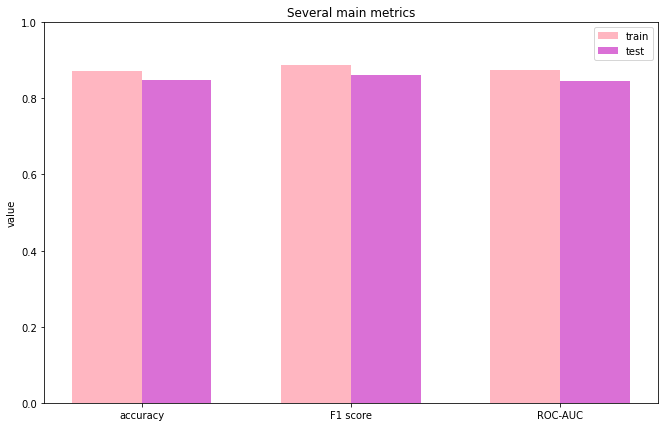

In [31]:
print("k =", k_best, '\n')

model = KNeighborsClassifier(n_neighbors=k_best)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate(model, y_train_pred, y_train, y_test_pred, y_test)

Получаем вполне хорошие метрики для данного метода.

#4.2 Logistic Regression

Train accuracy: 0.8759342301943199
Test  accuracy: 0.8430493273542601

Train F1 score: 0.8897742363877822
Test  F1 score: 0.8547717842323652

Train ROC-AUC: 0.8765487938596492
Test  ROC-AUC: 0.8412025827280064


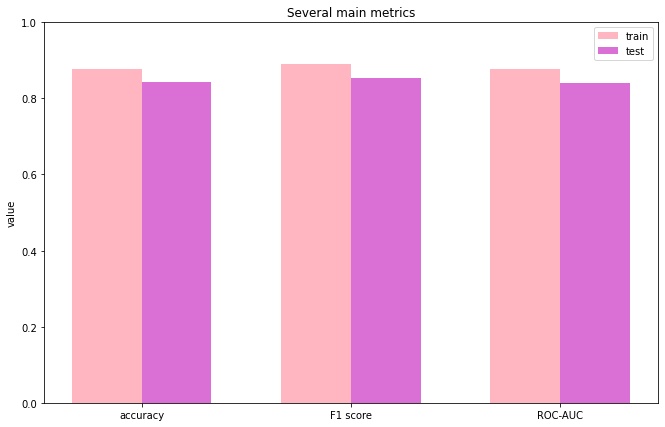

In [32]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate(model, y_train_pred, y_train, y_test_pred, y_test)

*Вывод*: все значения метрик остаются приблизительно на том же уровне, поэтому рассматривать далее базовые модели становится не так интересно, давайте перейдем к решающим деревьям.

#4.3 Decision Tree

Посмотрим, как влияют разные значения гиперпараметров решающего дерева на его метрики:
* `max_depth`: максимальная глубина дерева
* `min_samples_leaf`: минимальное число объектов в вершине дерева, необходимое для того, чтобы она стала листовой

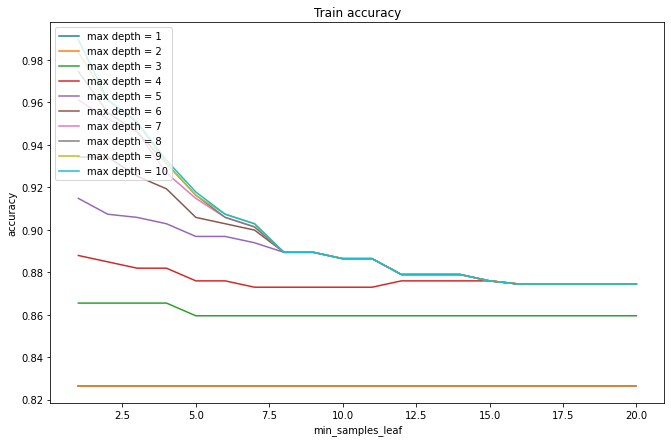

In [33]:
accuracy_train_hist = np.empty((10, 20), dtype='float32')
accuracy_test_hist = np.empty((10, 20), dtype='float32')

max_depth_best = 1
min_samples_leaf_best = 1
max_accuracy = 0

for i, max_depth in enumerate(range(1, 11)):
  for x, min_samples_leaf in enumerate(range(1, 21)):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    accuracy_train_hist[i, x] = accuracy_score(y_train_pred, y_train)
    accuracy_test_hist[i, x] = accuracy_score(y_test_pred, y_test)

    if (accuracy_test_hist[i, x] > max_accuracy):
      max_accuracy = accuracy_test_hist[i, x]
      max_depth_best = max_depth
      min_samples_leaf_best = min_samples_leaf

legends = ['max depth = ' + str(i) for i in range(1, 11)]
plt.figure(figsize=(11, 7))
for i in range(10):
  plt.plot(range(1, 21), accuracy_train_hist[i])
  plt.title('Train accuracy')
  plt.xlabel('min_samples_leaf')
  plt.ylabel('accuracy')
  plt.legend(legends, loc='upper left')

Теперь посмотрим, что было на тестовой выборке:

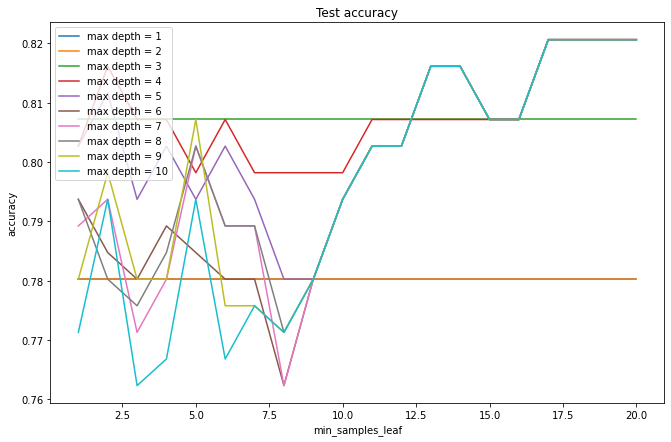

In [34]:
plt.figure(figsize=(11, 7))
for i in range(10):
  plt.plot(range(1, 21), accuracy_test_hist[i])
  plt.title('Test accuracy')
  plt.xlabel('min_samples_leaf')
  plt.ylabel('accuracy')
  plt.legend(legends, loc='upper left')
pass

По подобранным значениям глубины и по минимальному числу объектов в вершине посмотрим на следующие метрики:

max_depth = 4
min_samples_leaf = 17 

Train accuracy: 0.874439461883408
Test  accuracy: 0.820627802690583

Train F1 score: 0.8888888888888888
Test  F1 score: 0.84

Train ROC-AUC: 0.8755978888339107
Test  ROC-AUC: 0.8196358267716535


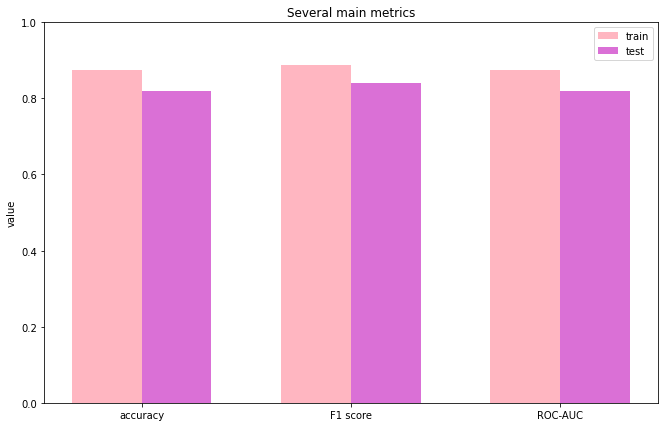

In [35]:
print("max_depth =", max_depth_best)
print("min_samples_leaf =", min_samples_leaf_best, '\n')

model = DecisionTreeClassifier(max_depth=max_depth_best, min_samples_leaf=min_samples_leaf)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate(model, y_train_pred, y_train, y_test_pred, y_test)

К сожалению, решающее дерево не дало прироста к показателям метрик на тестовой выборке. Может быть, ансамбли деревьев помогут улучшить показатели?

#4.4 Random Forest

Если запустить случайный лес без подбора гиперпараметров, то можно увидеть переобучение, в котором все метрики на обучающей выборке равны 1. В этот раз подбор будет осуществляться по метрике `F1 score`, и ограничимся только подбором по глубине дерева:

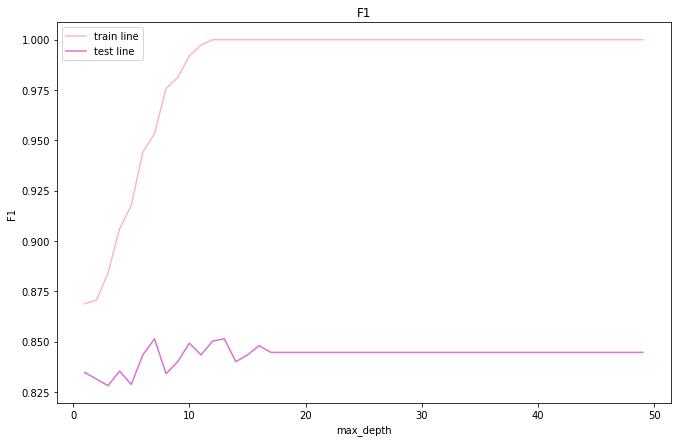

In [36]:
f1_train_score_hist = []
f1_test_score_hist = []
max_depth_best = 1
max_f1_score = 0

for max_depth in range(1, 50):
  model = RandomForestClassifier(max_depth=max_depth, random_state=7)
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  f1_train_score_hist.append(f1_score(y_train_pred, y_train))
  f1_test_score_hist.append(f1_score(y_test_pred, y_test))

  if (f1_test_score_hist[-1] > max_f1_score):
    max_f1_score = f1_test_score_hist[-1]
    max_depth_best = max_depth

plt.figure(figsize=(11, 7))
line_train, = plt.plot(range(1, 50), f1_train_score_hist, color='lightpink')
line_test, = plt.plot(range(1, 50), f1_test_score_hist, color='orchid')
plt.legend((line_train, line_test), ['train line', 'test line'])
plt.title('F1')
plt.xlabel('max_depth')
plt.ylabel('F1')
pass

На графике демонстрируется явное переобучение, из которого можно сделать вывод, что нет смысла строить дерево глубже 10. Давайте выведем *наилучшую* глубину и посмотрим на остальные метрики:

max_depth = 7 

Train accuracy: 1.0
Test  accuracy: 0.8251121076233184

Train F1 score: 1.0
Test  F1 score: 0.8446215139442231

Train ROC-AUC: 1.0
Test  ROC-AUC: 0.8245888157894737


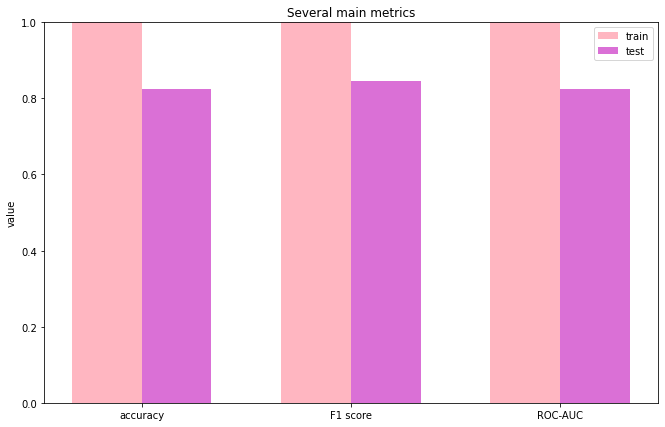

In [37]:
print("max_depth =", max_depth_best, '\n')

model = RandomForestClassifier(max_depth=max_depth, random_state=7)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate(model, y_train_pred, y_train, y_test_pred, y_test)

Построим матрицу ошибок и посмотрим на результаты:

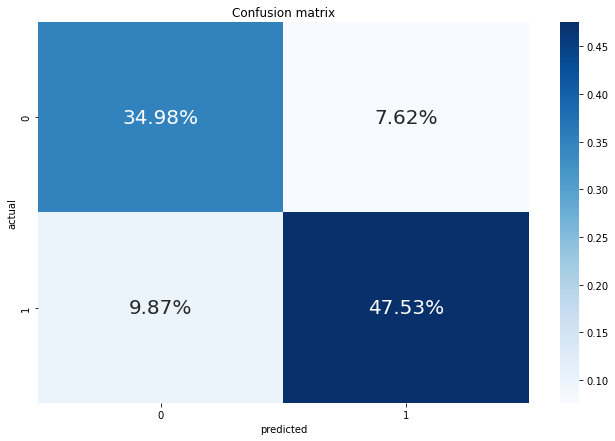

In [38]:
plt.figure(figsize=(11, 7))
conf_mat = confusion_matrix(y_test_pred, y_test)
p = sns.heatmap(conf_mat / conf_mat.sum(), annot=True, fmt='.2%', annot_kws={"size":20}, cmap='Blues')
p.set_xlabel("predicted")
p.set_ylabel("actual")
_ = p.set_title("Confusion matrix")

In [39]:
print("precision:", precision_score(y_test_pred, y_test))
print("recall:", recall_score(y_test_pred, y_test))

precision: 0.8617886178861789
recall: 0.828125


*Вывод*: показатели FN и FP практически равные, что сказывается на схожих значениях метрик `precision` и `recall`. Приблизительное равенство этих метрик и показатель **F1 score 0.84** позволяет оценить классификацию, как неплохой результат решения задачи.

#5. Выводы

* Данный датасет содержит относительно небольшое количество данных, в которых имеются некоторые пропуски, в основном - это нулевой холестерин, что в реальности быть не может. Около половины признаков имеют категориальные значения, которые следует правильно обрабатывать. Количественных признаков всего 12, между ними низкая корреляция и понижать признаковую размерность в данной задаче не требуется. 

* Спектр рассмотренных моделей с выполненным подбором гиперпараметров неожиданным образом говорит нам о том, что более простые модели показывают схожий и даже более высокий результат по метрикам тестовой выборки, чем дерево решений и их ансамбль в виде случайного леса. Все модели выдают примерно одинаковый результат на тестовой выборке (о тренировочной говорить не приходится, так как деревья можно сильно переобучить). В то же время подбор гиперпараметров являлся важным пунктым в построении наилучшей модели под конкретные данные, что дало хороший прирост в качестве, если сравнивать со стандартными гиперпараметрами, которые предустанавливает scikit-learn для своих методов.

* *Совет*: мужчинам после 50 лет следует быть наиболее внимательными к своему организму, как минимум, необходимо проверять уровень сахара натощак и следить за сердцебиением после физической активности. У многих пациентов боль при развитии сердечной недостаточности была бессимптомной, что заставляет обращать внимание на самые мелкие признаки.